In [1]:
from crime_util import *
import warnings

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data

## Import

I originally built my models from Florida crime data (2017), and will use crime data from Michigan, North Carolina and Ohio to validate the models.

In [2]:
(florida, michigan, nc, ohio) = read_data()

In [4]:
florida.population.describe()

count     255.000
mean    18254.416
std     19431.924
min        92.000
25%      3620.000
50%     10679.000
75%     24929.500
max     79918.000
Name: population, dtype: float64

## Transform

I previously conducted [research](https://github.com/mkm29/DataScience/blob/master/thinkful/unit/2/4/challenge_crime_regression.ipynb) into optimal feature engineering, so I am simply going to use only the transformations that I ended up using in my models.

In [3]:
florida = transform_data(florida)
michigan = transform_data(michigan)
nc = transform_data(nc)
ohio = transform_data(ohio)

In [4]:
# Property crime is not linear with population. It starts off linear, however at a certain point
# it begind to "flatten" out, so we Box-cox transformed the property crime variable
# (those cases where property crime is 0 we added 1)
# add Box-Cox property crime
florida, florida_bc_lambda = boxcox_transform(florida)
michigan, michigan_bc_lambda = boxcox_transform(michigan)
nc, nc_bc_lambda = boxcox_transform(nc)
ohio, ohio_bc_lambda = boxcox_transform(ohio)

print("Box-Cox Lambda's\n******************")
print("Florida: {:.4f}".format(florida_bc_lambda))
print("Michigan: {:.4f}".format(michigan_bc_lambda))
print("North Carolina: {:.4f}".format(nc_bc_lambda))
print("Ohio: {:.4f}".format(ohio_bc_lambda))

Box-Cox Lambda's
******************
Florida: 0.1587
Michigan: 0.0884
North Carolina: 0.0747
Ohio: 0.0757


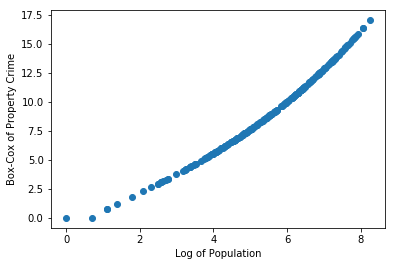

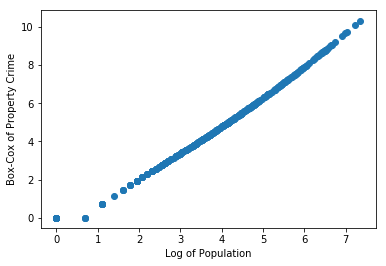

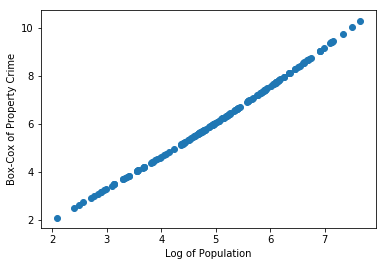

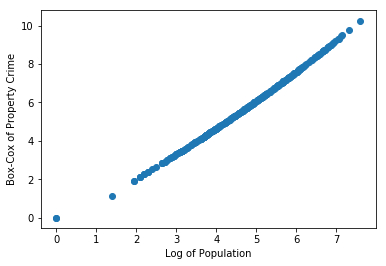

In [5]:
plt.scatter(florida["property_crime_log"], florida["property_crime_bc"])
plt.xlabel("Log of Population")
plt.ylabel("Box-Cox of Property Crime")
plt.show()

plt.scatter(michigan["property_crime_log"], michigan["property_crime_bc"])
plt.xlabel("Log of Population")
plt.ylabel("Box-Cox of Property Crime")
plt.show()

plt.scatter(nc["property_crime_log"], nc["property_crime_bc"])
plt.xlabel("Log of Population")
plt.ylabel("Box-Cox of Property Crime")
plt.show()

plt.scatter(ohio["property_crime_log"], ohio["property_crime_bc"])
plt.xlabel("Log of Population")
plt.ylabel("Box-Cox of Property Crime")
plt.show()

## Split

Split each state's data into a train and test set.

In [11]:
florida_train, florida_test = split(florida)
michigan_train, michigan_test = split(michigan)
nc_train, nc_test = split(nc)
ohio_train, ohio_test = split(ohio)

model_vars = ['population_log', "population_group",  "burglary_cube_root", "larceny_theft_cube_root"]

# Model

For this exercise, we are simply going to use model 3 from the previous exercise:

\begin{equation}\label{eq:}
PropertyCrime_{BoxCox} = 0.1328*Population_{log} + 0.5590*Robbery_{has} + 0.3989*Population_{Medium} - 0.1726*Robbery_{log} + 0.4324*\sqrt[3]{Burglary} + 0.8481*\sqrt[3]{Larceny} + 0.2094*VehicleTheft
\end{equation}


In [17]:
florida_results = build_model(florida_train, florida_test, florida_bc_lambda)
florida_model = florida_results[0]
florida_resids_train = florida_results[3]
florida_resids_test = florida_results[4]

florida["residuals_train"] = florida_results[1]
florida["residuals_test"] = florida_results[2]

                            OLS Regression Results                            
Dep. Variable:      property_crime_bc   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2843.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          1.52e-172
Time:                        09:46:03   Log-Likelihood:                -64.272
No. Observations:                 178   AIC:                             144.5
Df Residuals:                     170   BIC:                             170.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [16]:
michigan_results = build_model(michigan_train, michigan_test, michigan_bc_lambda)
michigan_model = michigan_results[0]
michigan_resids_train = michigan_results[3]
michigan_results_test = michigan_results[4]

michigan["residuals_train"] = michigan_results[1]
michigan["residuals_test"] = michigan_results[2]

                            OLS Regression Results                            
Dep. Variable:      property_crime_bc   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1623.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          1.11e-208
Time:                        09:45:33   Log-Likelihood:                -69.424
No. Observations:                 265   AIC:                             154.8
Df Residuals:                     257   BIC:                             183.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

*So for the state of Michigan, the second population group is less important on predicting property crime than Florida. After reversing the Box-Cox transform, the R-squared value (0.513) is really low.*

In [18]:
nc_results = build_model(nc_train, nc_test, nc_bc_lambda)
nc_model = nc_results[0]
nc_resids_train = nc_results[3]
nc_results_test = nc_results[4]

nc["residuals_train"] = nc_results[1]
nc["residuals_test"] = nc_results[2]

                            OLS Regression Results                            
Dep. Variable:      property_crime_bc   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     723.2
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           7.30e-89
Time:                        09:46:34   Log-Likelihood:                -4.6175
No. Observations:                 118   AIC:                             25.23
Df Residuals:                     110   BIC:                             47.40
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [19]:
ohio_results = build_model(ohio_train, ohio_test, ohio_bc_lambda)
ohio_model = ohio_results[0]
ohio_resids_train = ohio_results[3]
ohio_results_test = ohio_results[4]

ohio["residuals_train"] = ohio_results[1]
ohio["residuals_test"] = ohio_results[2]

                            OLS Regression Results                            
Dep. Variable:      property_crime_bc   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1076.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          4.25e-169
Time:                        09:46:58   Log-Likelihood:                -73.730
No. Observations:                 233   AIC:                             163.5
Df Residuals:                     225   BIC:                             191.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

*For the state of Ohio, population groups 2 and 5 are not statistically significant for this model, as is population log.*

## Residual Analysis

### Florida

In [20]:
florida_residuals = np.concatenate((florida["residuals_train"].dropna().values, florida["residuals_test"].dropna().values))
florida_percent_off = (florida["property_crime_2"] - florida_residuals) / florida["property_crime_2"]
np.abs(florida_percent_off).sum() / florida_percent_off.shape[0]

5.720043671207951

### Michigan

In [23]:
michigan_residuals = np.concatenate((michigan["residuals_train"].dropna().values, michigan["residuals_test"].dropna().values ))
michigan_percent_off = (michigan["property_crime_2"] - michigan_residuals) / michigan["property_crime_2"]
np.abs(michigan_percent_off).sum() / michigan_percent_off.shape[0]

6.945777075471556

### North Carolina

In [27]:
nc_residuals = np.concatenate((nc["residuals_train"].dropna().values, nc["residuals_test"].dropna().values))
nc_percent_off = (nc["property_crime_2"] - nc_residuals) / nc["property_crime_2"]
np.abs(nc_percent_off).sum() / nc_percent_off.shape[0]

2.7091299132347304

### Ohio

In [28]:
ohio_residuals = np.concatenate((ohio["residuals_train"].dropna().values, ohio["residuals_test"].dropna().values))
ohio_percent_off = (ohio["property_crime_2"] - ohio_residuals) / ohio["property_crime_2"]
np.abs(ohio_percent_off).sum() / ohio_percent_off.shape[0]

10.935347264776901

# Conclusion

By itself, the model that I propose for predicting property crime in Florida (2017) has a RMSE of 277.36 (on the test set), the same model on Michigan crime data has a RMSE of 236, 135.5 for North Carolina and 144.6 on Ohio data. There are obvious population dynamic differences among the states (as shown by the insignificance of population groups in Michigan and Ohio). Therefore, different models should be used for these states. 